In [2]:
%cd "d:/digimon-digital-card-battle-guide/backend/src/pytorchmon"
%pwd #execute twice to ignore warning

d:\Software Development\Public\digimon-digital-card-battle-guide\backend\src\pytorchmon


'd:\\Software Development\\Public\\digimon-digital-card-battle-guide\\backend\\src\\pytorchmon'

In [ ]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [ ]:
class CardFusionModel(nn.Module):
    """# each neuron -> function that returns a number from 0 to 1
    # card1, card2
    # each card has number, type, lv
    # 300 card samples with assigned type from 6 types, with assigned lv from 5 lv including 0 for no lv
    # so 300, 6, 5, 300, 6, 5 for each sample or row
    # in short sample size is 300 but each sample is an array of values
    # fact: while there are 300 cards, some cards are unobtainable through fusion, regardless
    # output may be 1 of the 300.
    # try output as an array or [number, type, lv]
    # fact: card1 + card 2 = card result
    # if card is an array or [number, type, lv]
    # [number, type, lv] + [number, type lv]
    # or [number, type, lv, number, type, lv]
    # so 6 inputs if number, type, lv, number, type lvl
    # but 2 inputs is clearer in array or [[number,type,lv],[number,type,lv]]
    # number(300), type(6), lv (0 or 4=5) organize in vector
    # # if 2D number image recognition is length x width or the number of pixels with values 0.0 black to 1.0 white
    # so input layer means regardless of values, in this case, 3 for number, type, lv
    # self.input = nn.Linear(3, 1) # 1 hidden, 1 neuron
    # ...
    # self.hidden1 = nn.Linear(1, 1) #1 neuron
    # self.hidden2 = nn.Linear(1, 1) #1 neuron
    # self.hidden3 = nn.Linear(1, 1) #1 neuron
    # ...
    # number(300)
    # self.output = nn.Linear(1, 300) # n neuron
    #
    # back propagation
    # average the sum of desired changes
    # stochastic gradiant descent
    # instead of finding the gradient descent one path
    # find the gradient descent by batches of n training
    # init weight?"""
    def __init__(self, inp, out, b=False, h1=None, h2=None):
        super(CardFusionModel, self).__init__()
        self.layer1 = nn.Linear(inp, out, bias=b)
        if h1 is not None:
            self.layer1 = nn.Linear(inp, h1, bias=b)
            self.hidden1 = torch.nn.ReLU()
            self.layer2 = nn.Linear(h1, out, bias=b)
        if h2 is not None:
            self.layer2 = nn.Linear(inp, h1, bias=b)
            self.hidden2 = torch.nn.ReLU()
            self.layer3 = nn.Linear(h1, out, bias=b)
    def forward(self, x):
        x = self.layer1(x)
        if hasattr(self, "layer2"):
            x = self.hidden1(x)
            x = self.layer2(x)
        if hasattr(self, "layer3"):
            x = self.hidden1(x)
            x = self.layer2(x)
        return x

In [410]:
card_fusion = pd.read_csv(Path("data/external/card_fusion.csv"))
card_fusion = card_fusion.to_numpy()
data = torch.Tensor(card_fusion)
print(data.shape)
_ = torch.unique(data[:,6], sorted=False, return_inverse=True)
unique = data[_[1].unique()]
print(unique)
print(unique.shape)

torch.Size([683, 9])
tensor([[143.,   5.,   6.,  ...,   6.,   1.,   6.],
        [110.,   4.,   6.,  ...,   6.,   1.,   6.],
        [108.,   4.,   6.,  ...,   2.,   1.,   6.],
        ...,
        [ 70.,   3.,   6.,  ..., 155.,   5.,   4.],
        [  2.,   1.,   6.,  ..., 155.,   5.,   4.],
        [105.,   4.,   6.,  ..., 155.,   5.,   4.]])
torch.Size([241, 9])


In [411]:
# test_x = data.detach()[:,:6]
# test_y = data.detach()[:,6:].to(dtype=torch.long)
test_x = unique.detach()[:,:6]
test_y = unique.detach()[:,6:].to(dtype=torch.long)
test_dataset = TensorDataset(test_x, test_y)

test_x, test_y = test_dataset.tensors
print(test_x.shape, test_x[-1])
print(test_y.shape, test_y[-1])

torch.Size([241, 6]) tensor([105.,   4.,   6.,  33.,   1.,   3.])
torch.Size([241, 3]) tensor([155,   5,   4])


In [435]:
# Run after train
# Make useful predictions
correct = 0
# test_loss = []
output_test = []
model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataset):
        y = y.select(dim=0,index=0)
        output = model(x)
        output_test.append(output.argmax().item())
        print(f"[i:{i}] X=Y: {x} = {y}\t is {output.argmax().item()}?")
        loss = (y - output).pow(2).sum()
        # test_loss.append(loss.detach().numpy())
        if output.argmax().item() == y.item():
            correct += 1

acc = correct / test_y.shape[0]
print(f"[{correct}/{test_y.shape[0]} Accuracy: {acc:.2f}]")

[i:0] X=Y: tensor([143.,   5.,   6., 113.,   4.,   6.]) = 6	 is 6?
[i:1] X=Y: tensor([110.,   4.,   6., 145.,   5.,   6.]) = 6	 is 3?
[i:2] X=Y: tensor([108.,   4.,   6.,  35.,   2.,   6.]) = 2	 is 2?
[i:3] X=Y: tensor([142.,   5.,   6., 115.,   4.,   6.]) = 2	 is 6?
[i:4] X=Y: tensor([ 37.,   2.,   6., 107.,   4.,   6.]) = 2	 is 2?
[i:5] X=Y: tensor([ 44.,   2.,   6., 110.,   4.,   6.]) = 7	 is 7?
[i:6] X=Y: tensor([108.,   4.,   6., 149.,   5.,   6.]) = 7	 is 4?
[i:7] X=Y: tensor([104.,   4.,   6.,  47.,   2.,   4.]) = 7	 is 7?
[i:8] X=Y: tensor([108.,   4.,   6.,  49.,   2.,   4.]) = 9	 is 8?
[i:9] X=Y: tensor([103.,   4.,   6., 156.,   5.,   4.]) = 9	 is 10?
[i:10] X=Y: tensor([140.,   5.,   6., 123.,   4.,   4.]) = 9	 is 9?
[i:11] X=Y: tensor([ 35.,   2.,   6., 111.,   4.,   6.]) = 3	 is 3?
[i:12] X=Y: tensor([109.,   4.,   6., 141.,   5.,   6.]) = 3	 is 3?
[i:13] X=Y: tensor([145.,   5.,   6., 106.,   4.,   6.]) = 5	 is 5?
[i:14] X=Y: tensor([146.,   5.,   6., 109.,   4.,   6.]) 

In [436]:
unique_output = torch.IntTensor(output_test).detach()
actual, actual_cnt = torch.unique(unique_output, sorted=False, return_counts=True)
expected, expected_cnt = torch.unique(test_y[:,0], sorted=False, return_counts=True)
print("Actual ?= Expected")
_ = 0
for i in range(len(expected)):
    s = "({:>3}) {:>3} ?= {:<3} ({:<3})"
    if _ < len(actual) and actual[_] in expected[i]:
        print(s.format(actual_cnt[_],actual[_],expected[i],expected_cnt[i]))
        _ +=1
    # else:
    #     print(s.format(0,expected[i],expected[i],expected_cnt[i]))

Actual ?= Expected
(  2)   2 ?= 2   (3  )
(  3)   3 ?= 3   (2  )
(  4)   4 ?= 4   (2  )
(  3)   5 ?= 5   (2  )
(  2)   6 ?= 6   (2  )
(  2)   7 ?= 7   (3  )
(  4)   8 ?= 8   (2  )
(  1)   9 ?= 9   (3  )
(  2)  10 ?= 10  (1  )
(  4)  13 ?= 13  (3  )
(  1)  14 ?= 14  (1  )
(  2)  15 ?= 15  (2  )
(  5)  16 ?= 16  (2  )
(  1)  17 ?= 17  (2  )
(  2)  19 ?= 19  (2  )
(  1)  21 ?= 21  (1  )


In [ ]:
# Run after test
filename = (
    f"{type(model).__name__}_gamefaq-526754-24611"
    f"_lr-{lr}_bs-{batch_size}"
    f"_epoch-{epochs:03d}"
    f"_acc-{acc:.2f}"
)
print(filename)

CardFusionModel_gamefaq-526754-24611_lr-0.001_bs-16_epoch-511_acc-0.74.pth


In [439]:
torch.save(model.state_dict(), f"result/{filename}.pt")

In [ ]:
model = CardFusionModel()
model.load_state_dict(torch.load(f"result/{filename}.pt"))

In [430]:
x = data.detach()[:,:6]
y = data.detach()[:,6:].to(dtype=torch.long)
# If entire dataset can fit into RAM
train_dataset = TensorDataset(x, y)
x, y = train_dataset.tensors
print(x.shape, x[-1])
print(y.shape, y[-1])
batch_size=2**4
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)
print(batch_size)

torch.Size([683, 6]) tensor([140.,   5.,   6., 165.,   5.,   3.])
torch.Size([683, 3]) tensor([203,   6,   0])
16


In [ ]:
class CardFusionModel(nn.Module):
    def __init__(self, inp, out, b=False, h1=None, h2=None, h3=None):
        # Finding right model
        super(CardFusionModel, self).__init__()
        self.layer1 = nn.Linear(inp, out, bias=b)
        if h1 is not None:
            self.layer1 = nn.Linear(inp, h1, bias=b)
            # nn.BatchNorm1d(h1),  # Batch normalization
            self.hidden1 = torch.nn.ReLU()
            self.layer2 = nn.Linear(h1, out, bias=b)
            # nn.LayerNorm(out)     # Layer normalization
        if h2 is not None:
            self.layer2 = nn.Linear(h1, h2, bias=b)
            # nn.BatchNorm1d(h1),  # Batch normalization
            # self.hidden2 = torch.nn.ReLU()
            # self.hidden2 = torch.nn.Softplus(threshold=OUTPUT_DIM)
            # self.hidden2 =  torch.nn.Softmax()
            self.hidden2 = torch.nn.LogSigmoid()
            self.layer3 = nn.Linear(h2, out, bias=b)
            # nn.LayerNorm(out)     # Layer normalization
        if h3 is not None:
            self.layer3 = nn.Linear(h2, h3, bias=b)
            # nn.BatchNorm1d(h1),  # Batch normalization
            # self.hidden2 = torch.nn.ReLU()
            # self.hidden2 = torch.nn.Softplus(threshold=OUTPUT_DIM)
            # self.hidden2 =  torch.nn.Softmax()
            self.hidden3 = torch.nn.ReLU()
            self.layer4 = nn.Linear(h3, out, bias=b)
            # nn.LayerNorm(out)     # Layer normalization

    def forward(self, x):
        x = self.layer1(x)
        if hasattr(self, "layer2"):
            x = self.hidden1(x)
            x = self.layer2(x)
        if hasattr(self, "layer3"):
            x = self.hidden2(x)
            x = self.layer3(x)
        if hasattr(self, "layer4"):
            x = self.hidden2(x)
            x = self.layer3(x)
            x = nn.Softmax()
        return x

In [ ]:
INPUT_DIM = 6
OUTPUT_DIM = 301
BIAS = False
# BIAS = True
# H1 = INPUT_DIM * 1
H1 = OUTPUT_DIM * 1
# H2 = INPUT_DIM * 1
H2 = OUTPUT_DIM * 1
H3 = OUTPUT_DIM *1

In [432]:
# Training the model for some number of iterations
lr = 0.001
#lr = 0.0001
model = CardFusionModel(INPUT_DIM,OUTPUT_DIM, b=BIAS, h1=H1)
# model = CardFusionModel(INPUT_DIM,OUTPUT_DIM, b=BIAS, h1=H1, h2=H2)
# model = CardFusionModel(INPUT_DIM,OUTPUT_DIM, b=BIAS, h1=H1, h2=H2, h3=H3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []

print(criterion)
print(optimizer)
print(model)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
)


In [433]:
# epochs = 2
epochs = 2 ** 9
b_part = 1
torch.backends.cudnn.deterministic = True
for epoch in range(epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(train_dataloader):
        batch_y = batch_y.select(dim=1,index=0)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()
        train_loss.append(loss.detach().numpy())
        if batch_idx % (batch_size // b_part) == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1*batch_size}], Loss: {loss.item():.4f}"
            )

chart = (
    f"lr-{lr}_bs-{batch_size}"
    f"_epoch-{epochs:03d}"
)
def plot():
    print(model)
    print(chart)
    plt.figure(figsize=(10,2))
    plt.plot(range(len(train_loss)),train_loss)
    plt.ylabel("loss")
    plt.xlabel("epoch")

Epoch [1/512], Batch [16], Loss: 41.3649
Epoch [1/512], Batch [32], Loss: 32.9503
Epoch [1/512], Batch [48], Loss: 94.2720
Epoch [2/512], Batch [16], Loss: 13.3770
Epoch [2/512], Batch [32], Loss: 13.4384
Epoch [2/512], Batch [48], Loss: 31.0755
Epoch [3/512], Batch [16], Loss: 17.7276
Epoch [3/512], Batch [32], Loss: 15.5359
Epoch [3/512], Batch [48], Loss: 13.1663
Epoch [4/512], Batch [16], Loss: 17.7011
Epoch [4/512], Batch [32], Loss: 15.1592
Epoch [4/512], Batch [48], Loss: 17.5433
Epoch [5/512], Batch [16], Loss: 16.9890
Epoch [5/512], Batch [32], Loss: 12.6069
Epoch [5/512], Batch [48], Loss: 17.1728
Epoch [6/512], Batch [16], Loss: 18.1126
Epoch [6/512], Batch [32], Loss: 17.1610
Epoch [6/512], Batch [48], Loss: 16.0664
Epoch [7/512], Batch [16], Loss: 12.0201
Epoch [7/512], Batch [32], Loss: 14.8661
Epoch [7/512], Batch [48], Loss: 18.5106
Epoch [8/512], Batch [16], Loss: 14.7267
Epoch [8/512], Batch [32], Loss: 9.4197
Epoch [8/512], Batch [48], Loss: 13.7926
Epoch [9/512], Ba

CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
)
lr-0.001_bs-16_epoch-512
acc-0.74


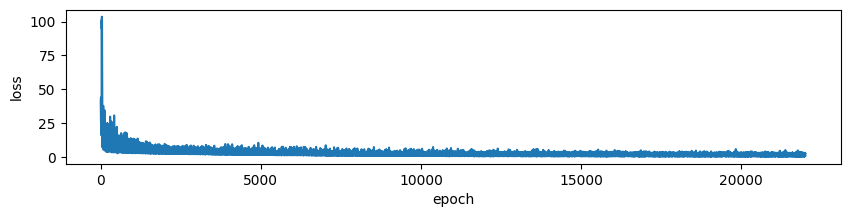

In [ ]:
plot() # current
print(f"acc-{acc:.2f}") #after test

CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
)
lr-0.001_bs-16_epoch-1024
acc-0.73


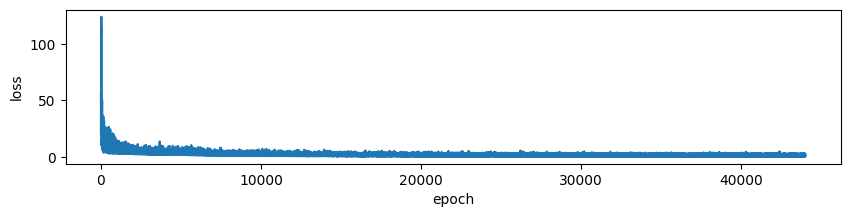

In [416]:
plot()
print(f"acc-{acc:.2f}") #after test
# wrong logic for accuracy below, will not redo

CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
)
lr-0.001_bs-16_epoch-128


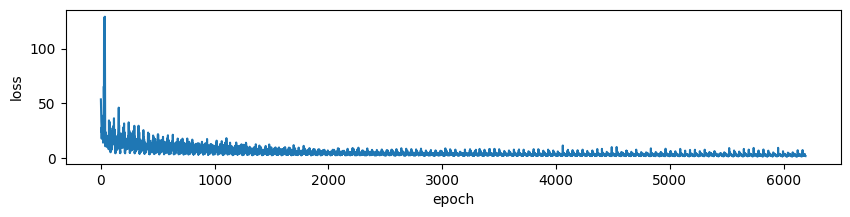

In [396]:
plot() # better direction?

CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
)
lr-0.001_bs-16_epoch-016


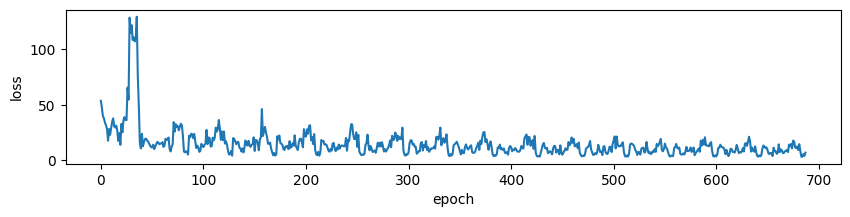

In [394]:
plot() # train dataset whole

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): LogSigmoid()
  (layer3): Linear(in_features=301, out_features=301, bias=False)
  (hidden3): ReLU()
  (layer4): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


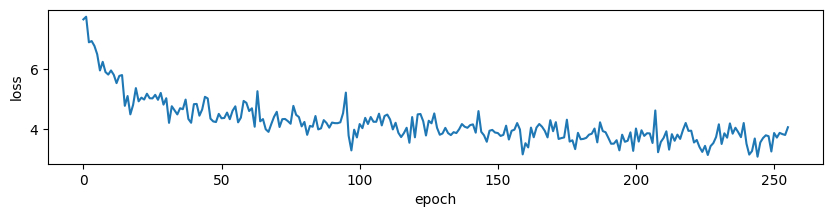

In [382]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): LogSigmoid()
  (layer3): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


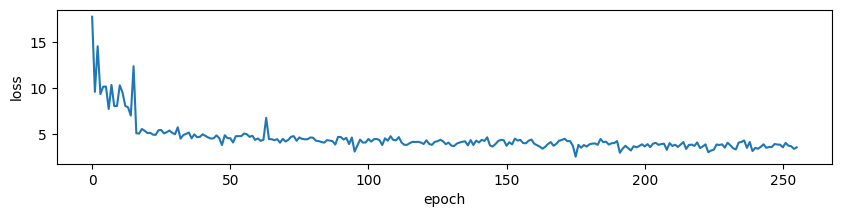

In [374]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): LogSigmoid()
  (layer3): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


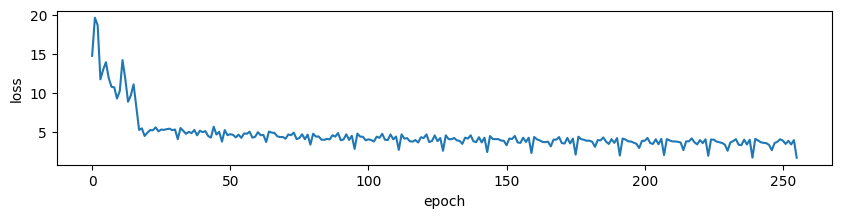

In [367]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): Softmax(dim=None)
  (layer3): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


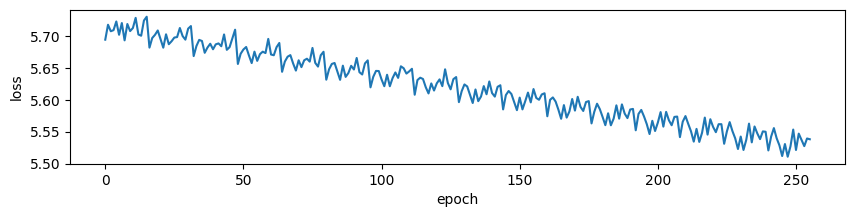

In [354]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): Softplus(beta=1.0, threshold=301)
  (layer3): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


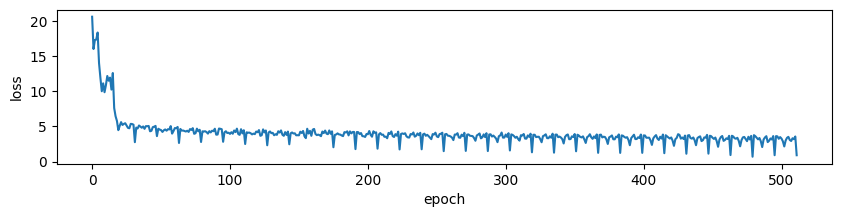

In [347]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): Softplus(beta=1.0, threshold=20.0)
  (layer3): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


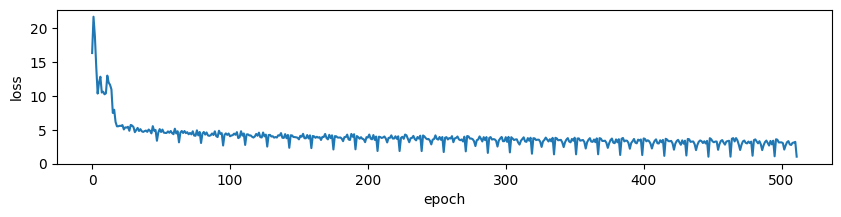

In [340]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=150, bias=False)
  (hidden2): ReLU()
  (layer3): Linear(in_features=150, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


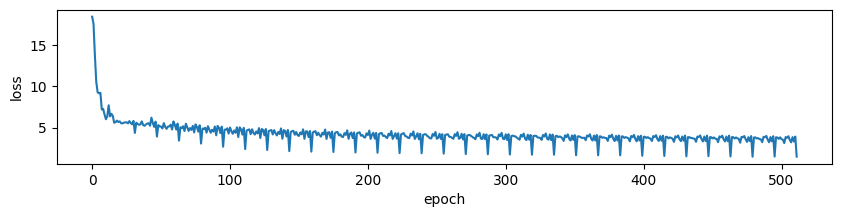

In [325]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
  (hidden2): ReLU()
  (layer3): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


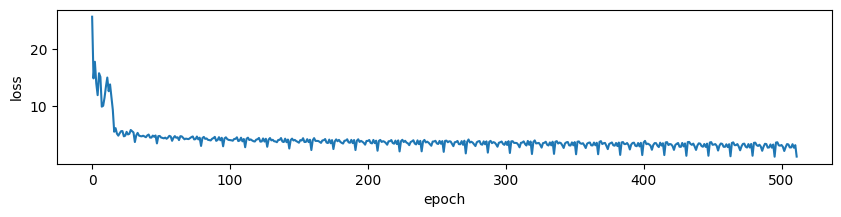

In [332]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


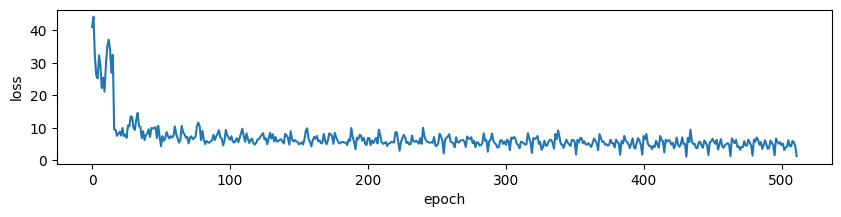

In [302]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=301, bias=True)
  (hidden1): ReLU()
  (layer2): Linear(in_features=301, out_features=301, bias=True)
)>
lr-0.001_bs-16_epoch-032


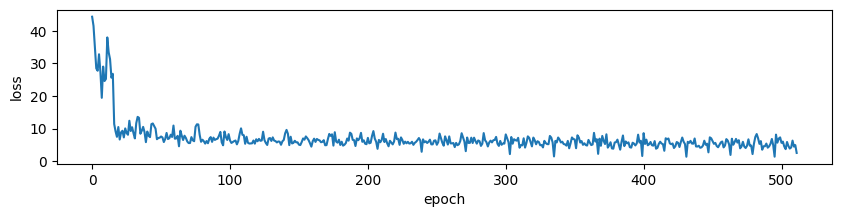

In [289]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=903, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=903, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


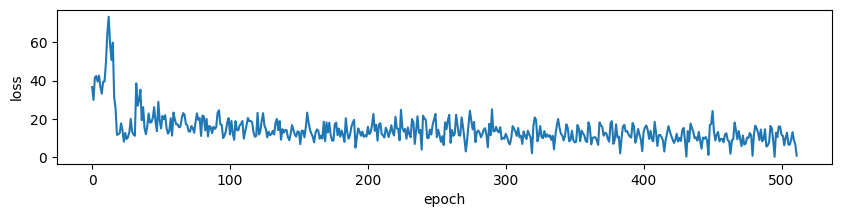

In [282]:
plot() # 301 seems the direction

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=602, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=602, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


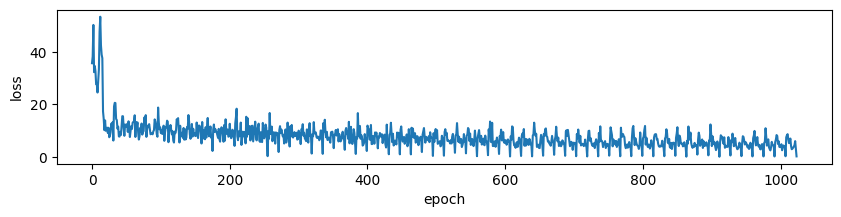

In [276]:
plot() # last 32 x2

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=602, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=602, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


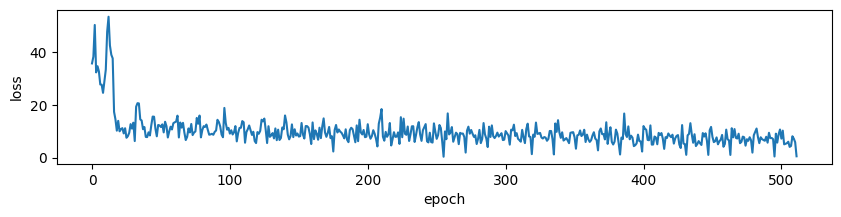

In [272]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=300, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=300, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


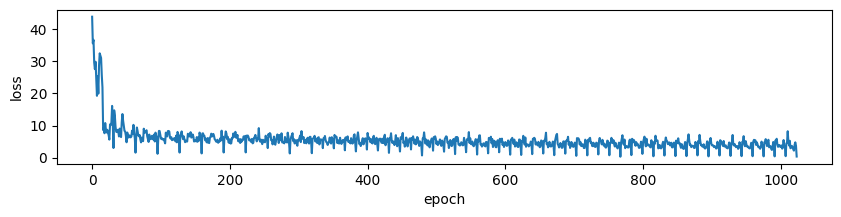

In [266]:
plot() # 32 x 2, maybe it's because of fixed data, but repeating not matter

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=300, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=300, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


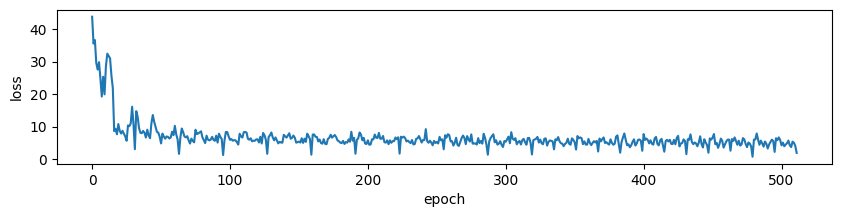

In [261]:
plot() # better direction, hidden size close to output size but still 1/301

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=12, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=12, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


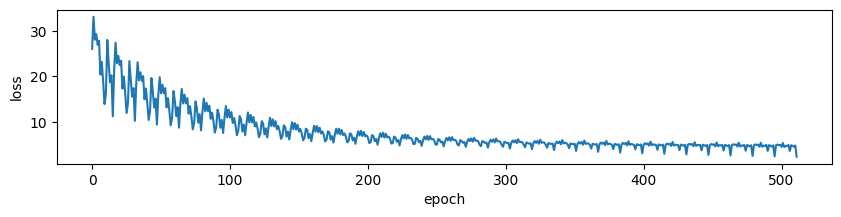

In [254]:
plot() # somewhat worse

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=5, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=5, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-032


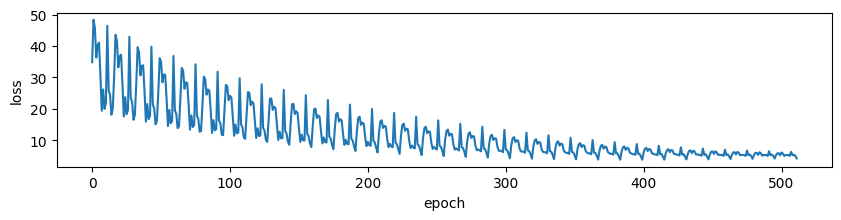

In [247]:
plot() # same but now stick to more number

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=5, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=5, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-128


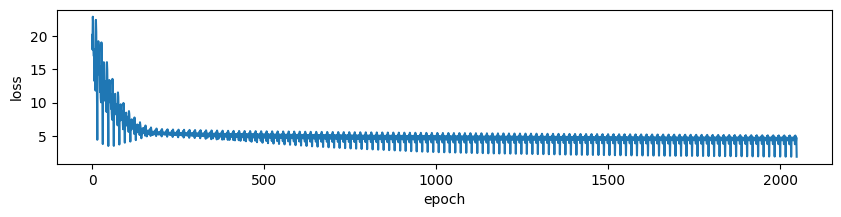

In [233]:
plot() # repeating will make model stick to a number

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=1, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=1, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


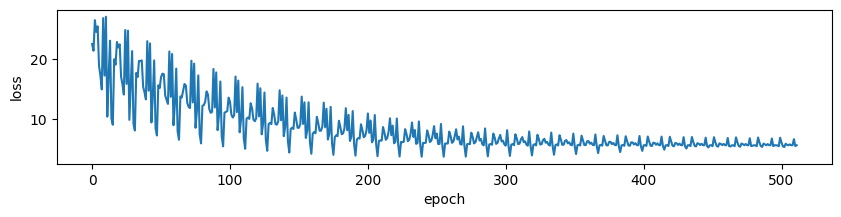

In [218]:
plot() # no hidden > 1 neuron hidden but still 1/301, 16 x 2 not matter

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=1, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=1, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


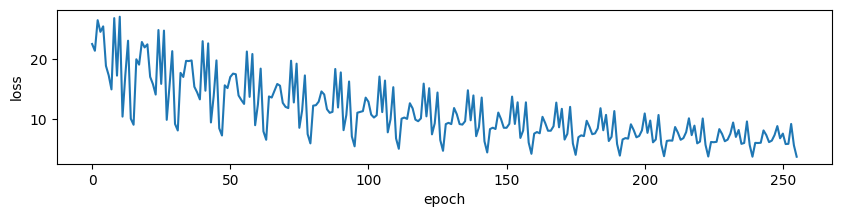

In [216]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=1, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=1, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-016


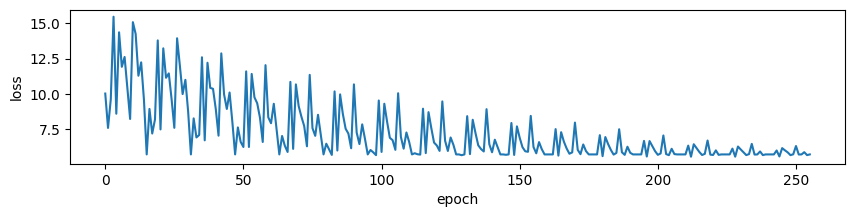

In [197]:
plot()

<bound method Module.parameters of CardFusionModel(
  (layer1): Linear(in_features=6, out_features=1, bias=False)
  (hidden1): ReLU()
  (layer2): Linear(in_features=1, out_features=301, bias=False)
)>
lr-0.001_bs-16_epoch-128


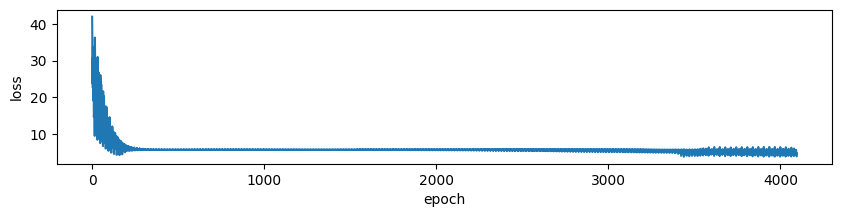

In [ ]:
plot() #128 x 2, before

lr-0.001_bs-16_epoch-128


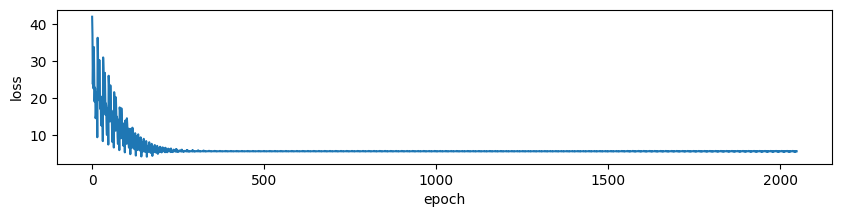

In [177]:
plot()

lr-0.001_bs-16_epoch-128


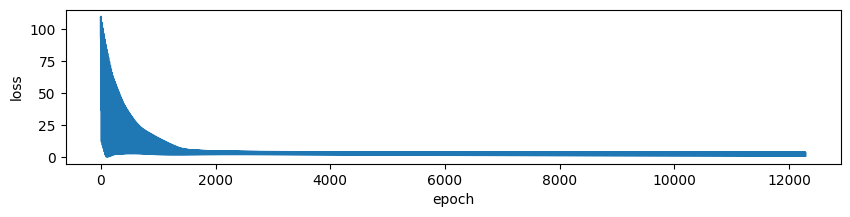

In [94]:
plot() # no bias, 128 x n 

lr-0.001_bs-16_epoch-128


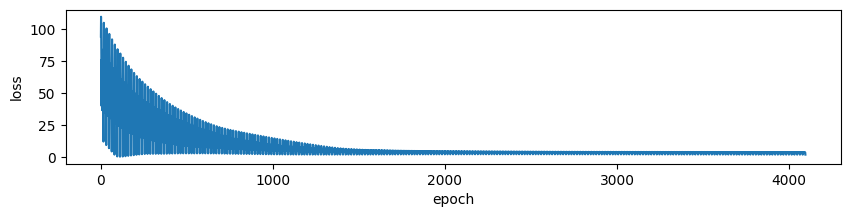

In [86]:
plot() # no bias

lr-0.001_bs-16_epoch-128


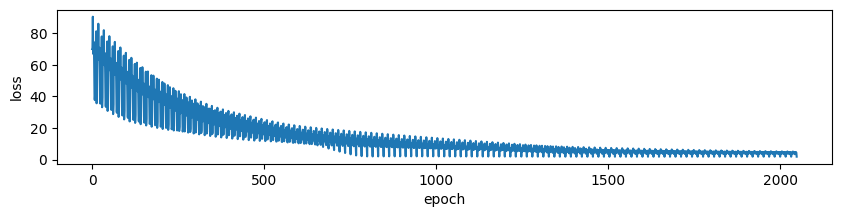

In [72]:
plot() #bias

lr-0.001_bs-16_epoch-128


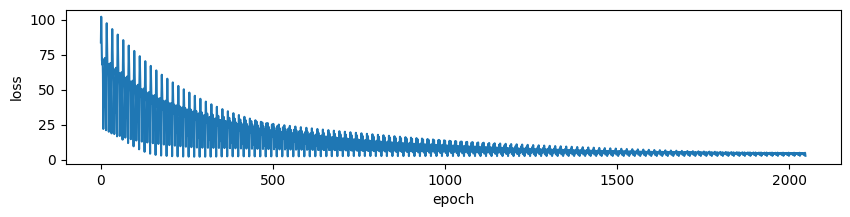

In [76]:
plot() #no bias, onwards

lr-0.001_bs-16_epoch-064


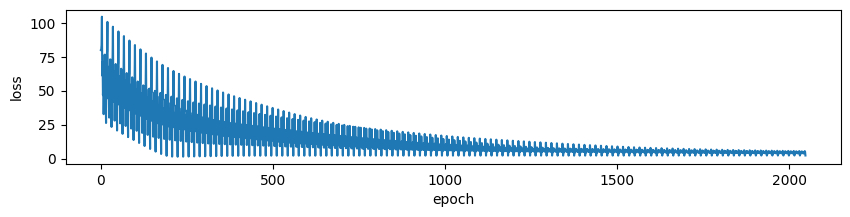

In [48]:
plot()

lr-0.001_bs-16_epoch-064


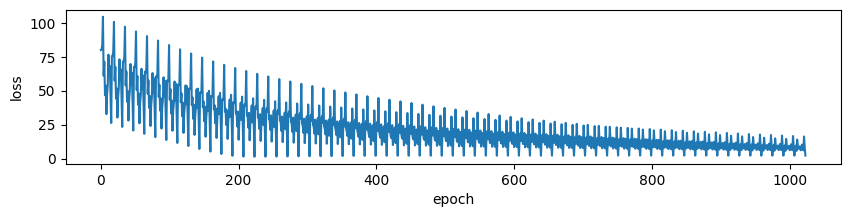

In [46]:
plot() #reset

lr-0.001_bs-16_epoch-256


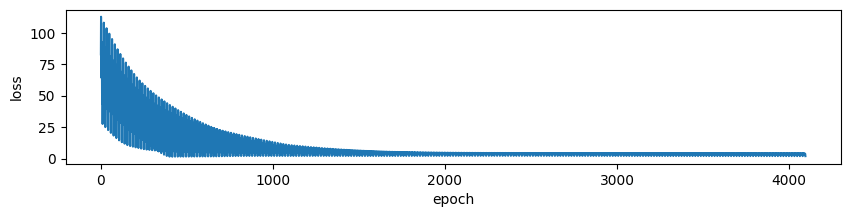

In [43]:
plot() #reset

lr-0.001_bs-16_epoch-112


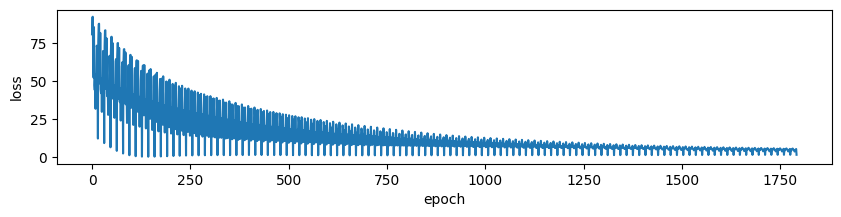

In [36]:
plot() #reset

lr-0.001_bs-16_epoch-016


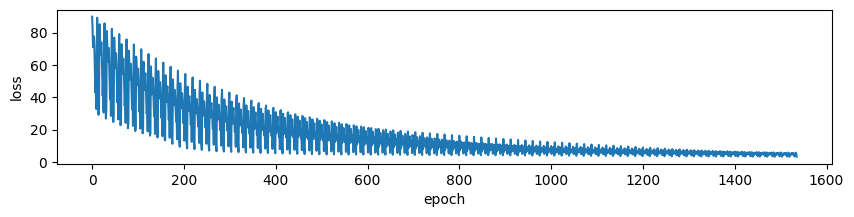

In [31]:
plot() #16x7

lr-0.001_bs-16_epoch-016


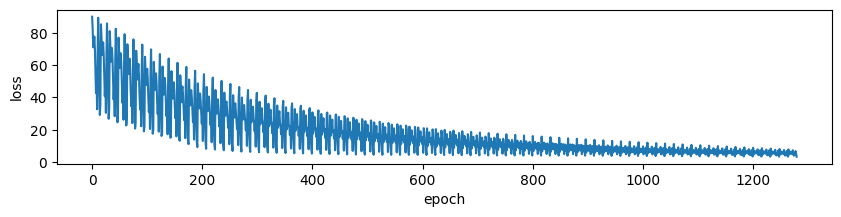

In [29]:
plot() #16x6

lr-0.001_bs-16_epoch-016


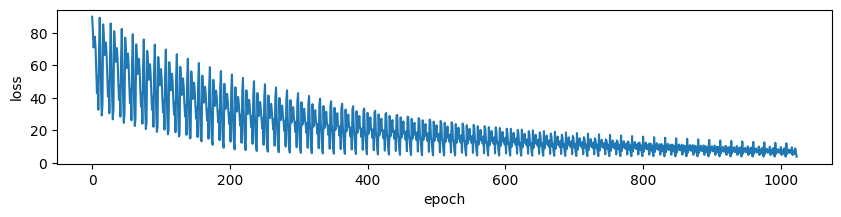

In [27]:
plot() #16x5

lr-0.001_bs-16_epoch-016


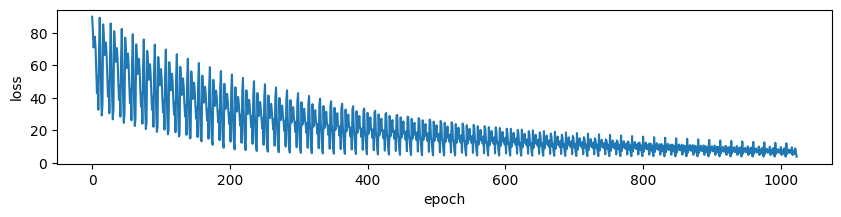

In [26]:
plot() #16x4

lr-0.001_bs-16_epoch-016


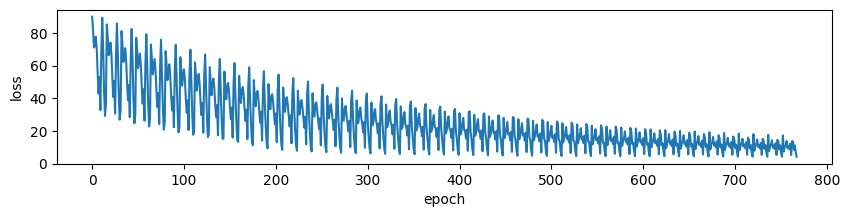

In [24]:
plot() #16x3

lr-0.001_bs-16_epoch-016


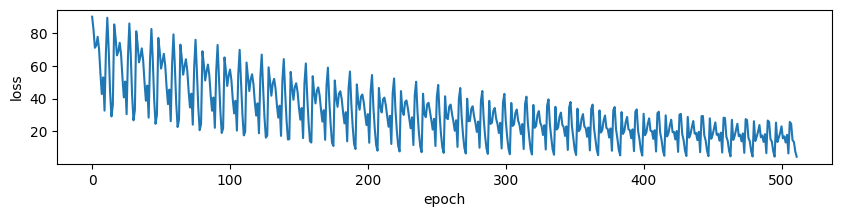

In [22]:
plot() #16x2

lr-0.001_bs-16_epoch-016


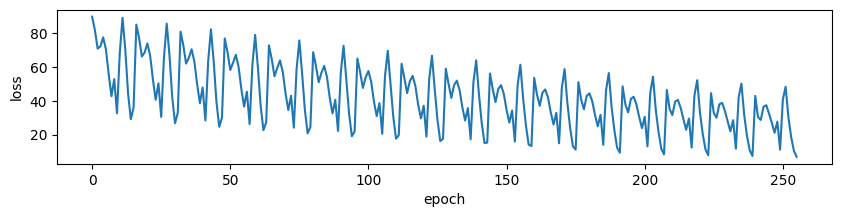

In [20]:
plot() #16x1

lr-0.001_bs-16_epoch-002


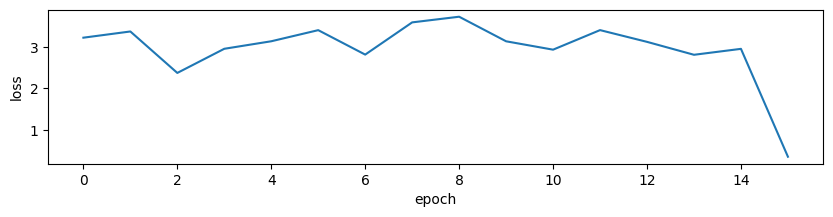

In [ ]:
plot() #number of work 1 slow, same below, increase epoch by 1

lr-0.001_bs-16_epoch-001


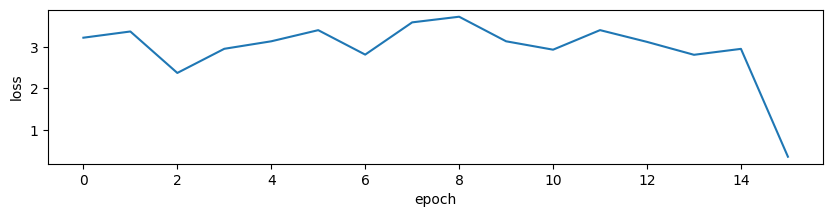

In [ ]:
plot() #num of worker 0, same above, initial epoch

lr-0.001_bs-80_epoch-001


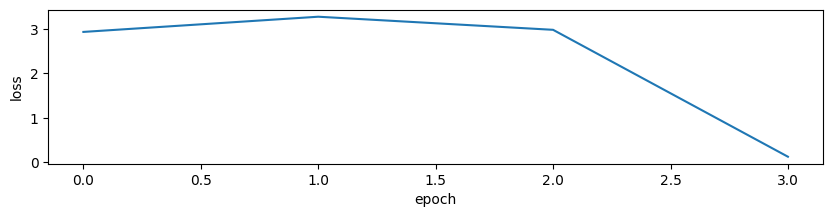

In [ ]:
plot() #num of worker 0, same below

lr-0.001_bs-80_epoch-001


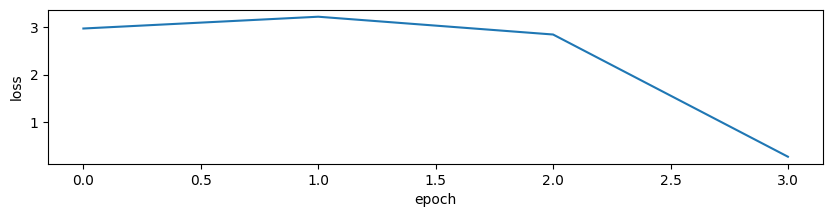

In [ ]:
plot() #num of worker 1 slow, same above

lr-0.001_bs-16_epoch-002


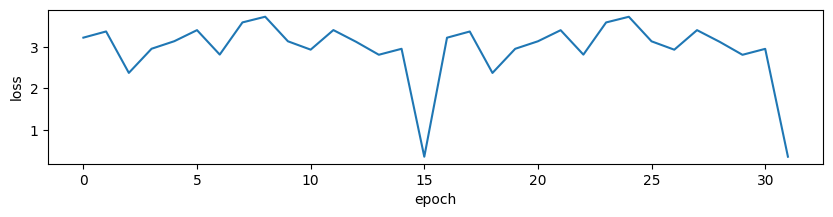

In [393]:
plot() #increase epoch by 1

lr-0.001_bs-16_epoch-008


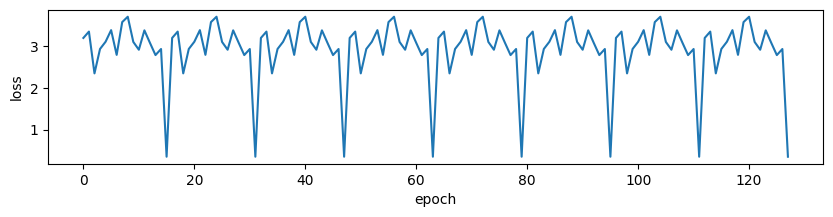

In [ ]:
plot() # S increase epoch, patterns repeats

lr-0.001_bs-16_epoch-026


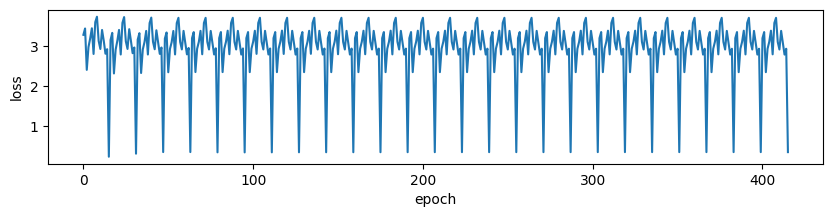

In [ ]:
plot() #S increase epoch

lr-0.001_bs-16_epoch-080


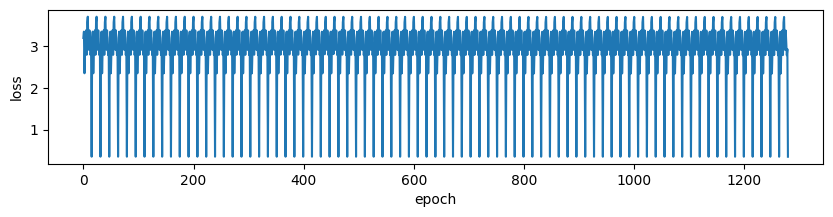

In [ ]:
plot() #big increase epoch

lr-0.001_bs-16_epoch-001


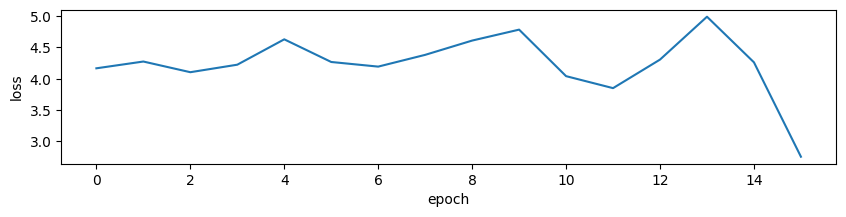

In [462]:
plot()

lr-0.001_bs-16_epoch-002


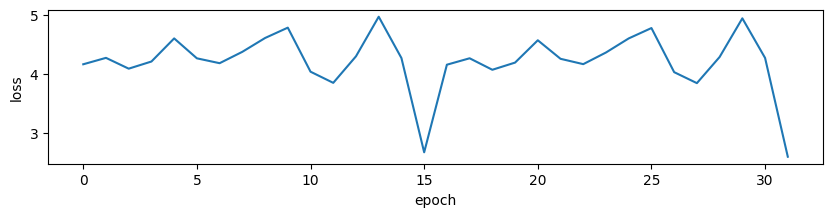

In [464]:
plot()

lr-0.001_bs-16_epoch-016


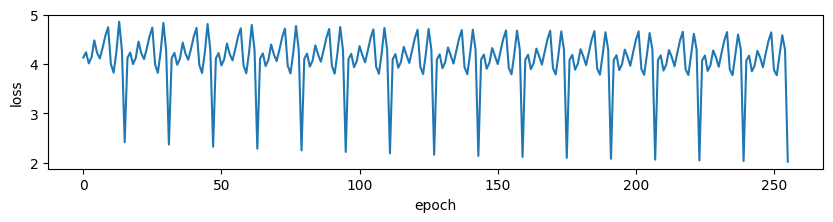

In [468]:
plot()

lr-0.001_bs-16_epoch-064


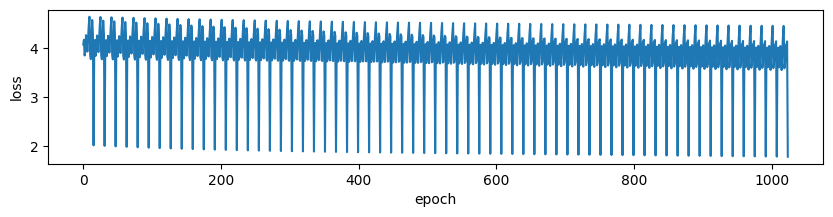

In [470]:
plot()

lr-0.001_bs-16_epoch-096


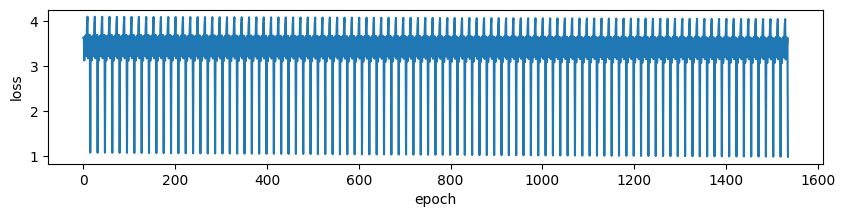

In [475]:
plot()

lr-0.001_bs-16_epoch-128


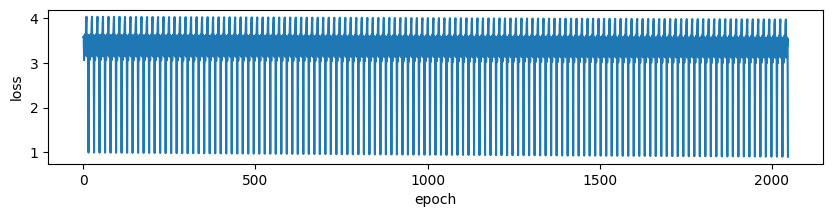

In [477]:
plot()

lr-0.001_bs-16_epoch-128


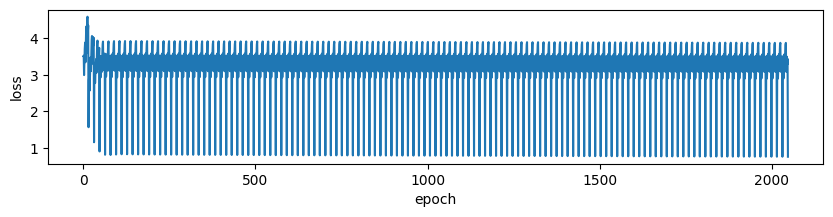

In [481]:
plot()

lr-0.001_bs-16_epoch-128


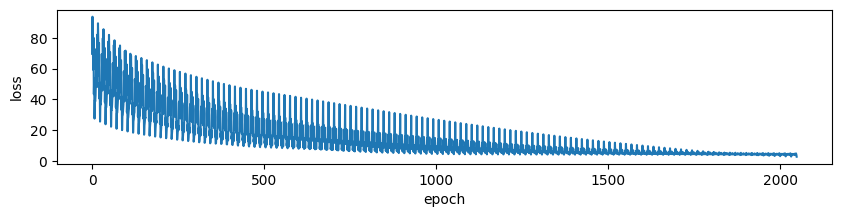

In [457]:
plot()

lr-0.001_bs-16_epoch-256


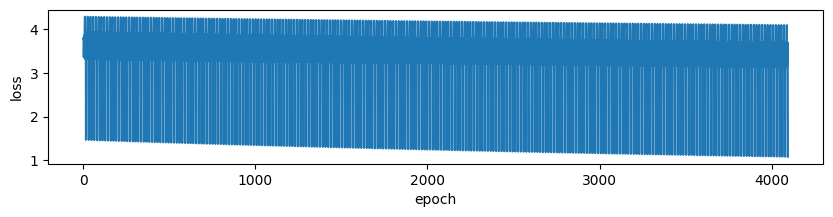

In [473]:
plot()

lr-0.001_bs-16_epoch-256


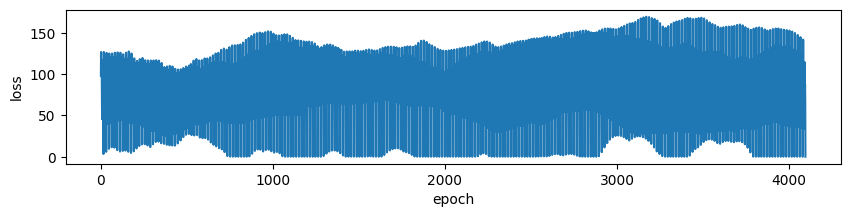

In [ ]:
plot() #optimizer.zero_grad outside loop, above is zero_grad before and after optimizer.step

lr-0.001_bs-16_epoch-128


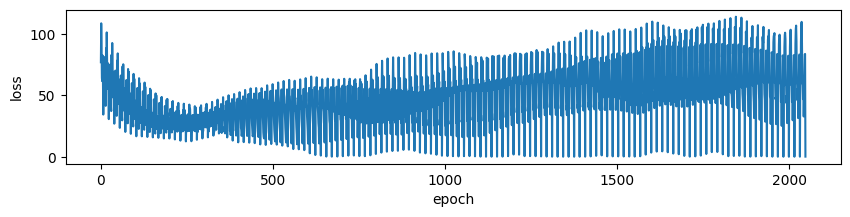

In [ ]:
plot() #optimizer.zero_grad outside loop, above is zero_grad before and after optimizer.step

lr-0.001_bs-16_epoch-128


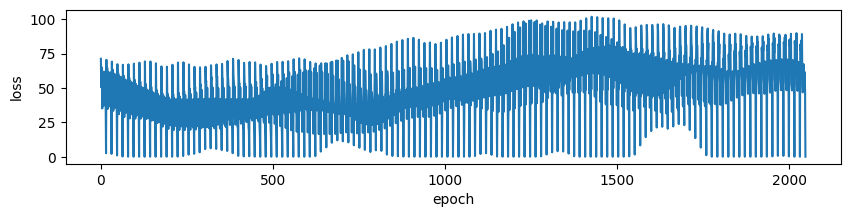

In [23]:
plot()

lr-0.001_bs-16_epoch-064


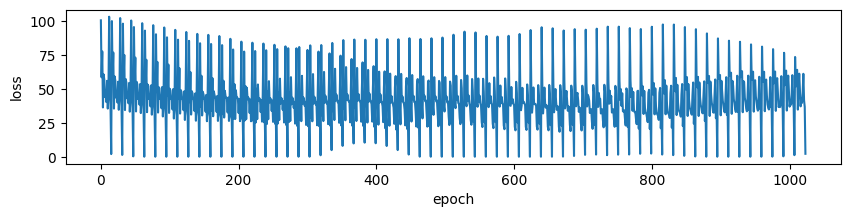

In [21]:
plot()

lr-0.001_bs-16_epoch-016


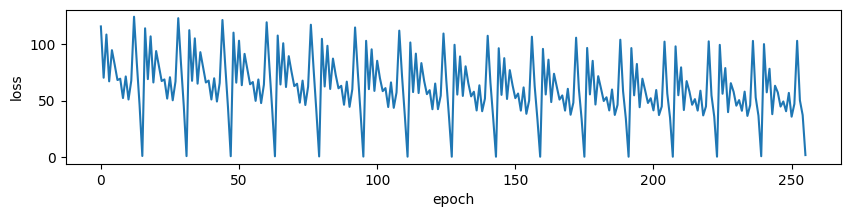

In [19]:
plot()

lr-0.001_bs-16_epoch-001


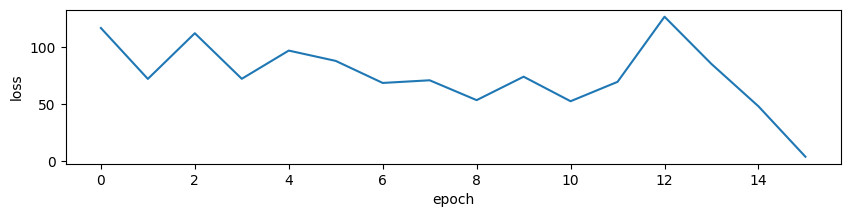

In [16]:
plot()

lr-0.001_bs-16_epoch-128


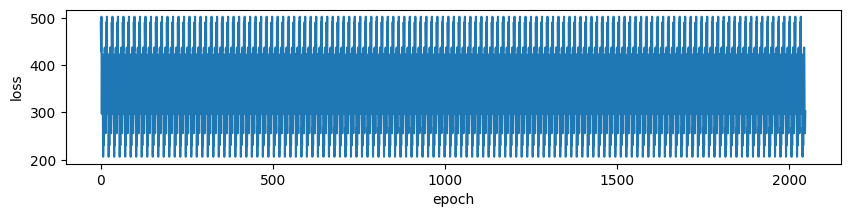

In [55]:
plot()

lr-0.001_bs-16_epoch-016


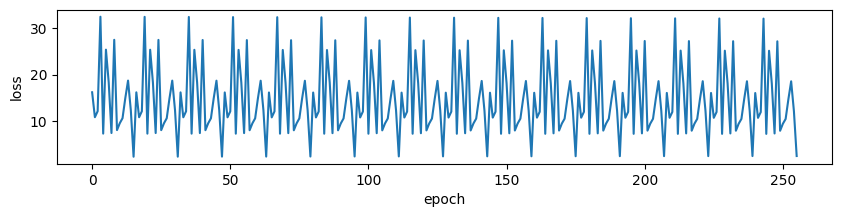

In [15]:
plot()